In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [149]:
OD = 14.03  # mm
L0 = 10.45  # mm
A = 0.25*np.pi*OD**2  # mm^2
f = 10  # Hz
w = 2*np.pi*f  # rad/s
disp_offset = -0.025
A
print(f"{A=} {w=}")

A=154.59848134150076 w=62.83185307179586


In [150]:
rdr_data = pd.read_csv("lab_RDR.csv")
rdr_data["Disp [mm]"] = rdr_data["Disp [mm]"]-disp_offset
rdr_data["Strain [mm/mm]"] = rdr_data["Disp [mm]"]/L0
rdr_data["Stress [MPa]"] = rdr_data["Load [N]"]/A
rdr_data.columns

Index(['Points', 'Time [s]', 'Disp [mm]', 'Load [N]', 'Strain [mm/mm]',
       'Stress [MPa]'],
      dtype='object')

In [151]:
std_data = pd.read_csv("lab_STD.csv")
std_data["Disp [mm]"] = std_data["Disp [mm]"]-disp_offset
std_data["Strain [mm/mm]"] = std_data["Disp [mm]"]/L0
std_data["Stress [MPa]"] = std_data["Load [N]"]/A
std_data.columns

Index(['Points', 'Time [s]', 'Disp [mm]', 'Load [N]', 'Strain [mm/mm]',
       'Stress [MPa]'],
      dtype='object')

In [152]:
std_data

,Points,Time [s],Disp [mm],Load [N],Strain [mm/mm],Stress [MPa]
0,1,0.000,0.021934,0.03,0.002099,0.000194
1,2,0.005,0.022207,0.04,0.002125,0.000259
2,3,0.010,-0.003542,0.03,-0.000339,0.000194
3,4,0.015,-0.122979,-0.09,-0.011768,-0.000582
4,5,0.020,-0.318741,-0.28,-0.030502,-0.001811
...,...,...,...,...,...,...
1995,16,9.975,-1.464561,-1.56,-0.140149,-0.010091
1996,17,9.980,-1.203103,-0.67,-0.115129,-0.004334
1997,18,9.985,-0.901228,-0.07,-0.086242,-0.000453
1998,19,9.990,-0.604538,0.27,-0.057851,0.001746


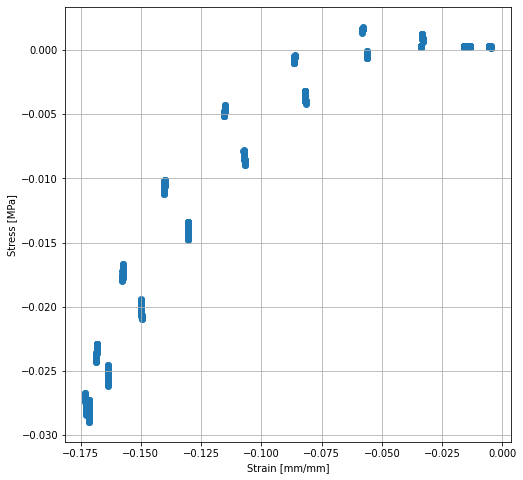

In [153]:
# Plot stress and strain curves
dataset = rdr_data  # rdr_data, std_data
x_label = "Strain [mm/mm]"
y_label = "Stress [MPa]"

fig = plt.figure(figsize=(8,8))
ax = fig.subplots(nrows=1, ncols=1)
ax.scatter(dataset[x_label], dataset[y_label])
# ax.plot(dataset[x_label], dataset[y_label])
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.grid()


In [191]:
dataset = rdr_data  # rdr_data, std_data
graph_limit = 100
x_label = "Time [s]"
stress_label = "Stress [MPa]"
strain_label = "Strain [mm/mm]"
subset = dataset[:graph_limit]

In [192]:
from scipy.signal import argrelextrema
stress_ilocs_min = argrelextrema(subset[stress_label].values, np.less_equal, order=3)[0]
stress_ilocs_max = argrelextrema(subset[stress_label].values, np.greater_equal, order=3)[0]
strain_ilocs_min = argrelextrema(subset[strain_label].values, np.less_equal, order=3)[0]
strain_ilocs_max = argrelextrema(subset[strain_label].values, np.greater_equal, order=3)[0]

In [193]:
peak_stress = max(subset[stress_label].iloc[stress_ilocs_max]) - min(subset[stress_label].iloc[stress_ilocs_min])
peak_strain = max(subset[strain_label].iloc[strain_ilocs_max]) - min(subset[strain_label].iloc[strain_ilocs_min])
print(f"{peak_stress=} {peak_strain=}")

peak_stress=0.030466017254049425 peak_strain=0.1680839234449761


In [194]:
strain_ilocs_min

array([ 2, 22, 42, 62, 82, 99], dtype=int64)

In [195]:
stress_ilocs_min

array([ 1, 11, 21, 41, 61, 81, 91, 99], dtype=int64)

In [196]:
subset[x_label].iloc[22]-subset[x_label].iloc[21]

0.0050000000000000044

In [197]:
import scipy.optimize
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    # ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    # Fyy = abs(np.fft.fft(yy))
    # guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    # guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])
    # def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    # popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    # A, w, p, c = popt  # amp, omega, phase, offset
    # Use know frequency
    guess = np.array([guess_amp, 0., guess_offset])
    def sinfunc(t, A, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, p, c = popt  # amp, phase, offset
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "fitfunc": fitfunc}


In [198]:
stress_fit = fit_sin(subset[x_label], subset[stress_label])
print(f"{stress_fit=}")
strain_fit = fit_sin(subset[x_label], subset[strain_label])
print(f"{strain_fit=}")

stress_fit={'amp': 0.014497904200966895, 'omega': 62.83185307179586, 'phase': -1.9349750976826776, 'offset': -0.0093901310504677, 'fitfunc': <function fit_sin.<locals>.<lambda> at 0x0000020324A5E0D0>}
strain_fit={'amp': -0.08487319068960433, 'omega': 62.83185307179586, 'phase': 1.063111428765394, 'offset': -0.09331461052631979, 'fitfunc': <function fit_sin.<locals>.<lambda> at 0x0000020324A10DC0>}


In [199]:
lag = stress_fit["phase"]-strain_fit["phase"]
while lag>np.pi/2:
    lag -= np.pi/2
while lag<0:
    lag += np.pi/2
lag

0.1435061271417215

Text(0, 0.5, 'Strain [mm/mm]')

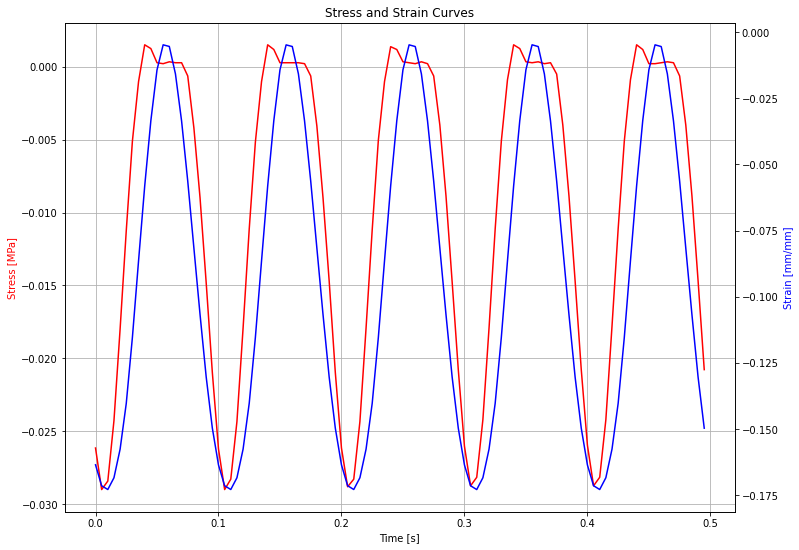

In [200]:
fig = plt.figure(figsize=(12,9))
ax_stress = fig.subplots(nrows=1, ncols=1)
plt.title("Stress and Strain Curves")

ax_stress.plot(subset[x_label], subset[stress_label], color='r', marker='.', label=stress_label)
ax_stress.set_ylabel(stress_label, color='r')
ax_stress.set_xlabel(x_label)
ax_stress.grid()
ax_stress.scatter(subset[x_label].iloc[stress_ilocs_min], subset[stress_label].iloc[stress_ilocs_min], color='r', marker="^")
ax_stress.scatter(subset[x_label].iloc[stress_ilocs_max], subset[stress_label].iloc[stress_ilocs_max], color='g', marker="v")

ax_strain = ax_stress.twinx()
ax_strain.plot(subset[x_label], subset[strain_label], color='b', label=strain_label)
ax_strain.set_ylabel(strain_label, color='b')
ax_strain.scatter(subset[x_label].iloc[strain_ilocs_min], subset[strain_label].iloc[strain_ilocs_min], color='r', marker="^")
ax_strain.scatter(subset[x_label].iloc[strain_ilocs_max], subset[strain_label].iloc[strain_ilocs_max], color='g', marker="v")

# fake_x_data = np.linspace(subset[x_label].min(), subset[x_label].max(), 2*graph_limit)
# ax_stress.plot(fake_x_data, stress_fit["fitfunc"](fake_x_data), color="r", lw=1)
# ax_strain.plot(fake_x_data, strain_fit["fitfunc"](fake_x_data), color="b", lw=1)


In [201]:
amp_stress = 0.01587  # MPa
amp_strain = 0.08402  # mm/mm
phase_angle = 0.3141

In [202]:
E_storage = amp_stress/amp_strain * np.cos(phase_angle)
E_loss = amp_stress/amp_strain * np.sin(phase_angle)
E_complex = amp_stress/amp_strain
print(f"{E_storage=} {E_loss=} {E_complex=}")

E_storage=0.17964243668562824 E_loss=0.0583575956229064 E_complex=0.18888359914306116
